# Data Scientist Case Study – Refined Analysis & Model Selection
---

## List of recommended changes


1. **Preprocessing improvements** 
- Removed redundant or collinear columns (MRC totals, duplicate demographic encodings like binary vs. MRC)
- Retained NA categories in Offer and Internet Type by mapping to No Offer or Unknown rather than dropping rows
- Mapped all binary and ordinal variables into consistent numeric encodings
2. **Better evaluation metrics**  
- Add PR-AUC (average precision) alongside ROC-AUC to account for class imbalance  
- Evaluate lift and threshold-based policies to align with business targeting  
3. **Model selection & explainability**  
- Compare multiple models via CV PR-AUC → Logistic Regression chosen for interpretability and performance  
- Present top features as key churn drivers (business actionable)

(Validation - not improvements)

- 390 customers were missing demographic data so I dropped these rows (same as original pipeline)
- Verified there were no duplicate CustomerIDxMonth rows
- Pressure tested the churn logic - once inactive, stayed inactive; no one inactive in Month 1
- Removed redundant cols to avoid multicollinearity before CV/models (MRC_TotalCharge, etc.)

Potential Changes (not implemented)
- Could handle missing demographic data differently if more time

-----

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
data_path = '/Users/username/Downloads/source-data.xlsx'
services = pd.read_excel(data_path, sheet_name='Services')
demographics = pd.read_excel(data_path, sheet_name='Demographics')
services.head()

,Customer ID,Month,Tenure in Months,Offer,Offer_ID,Phone Service,Multiple Lines,Number of Lines,Internet Service,Internet Type,...,MRC_InternetService,MRC_OnlineSecurity,MRC_OnlineBackUp,MRC_Protection,MRC_Tech,MRC_Data,MRC_SubTotal,MRC_TotalCharge_ContractDiscount,MRC_TotalCharge_PaymentTypeDiscount,MRC_TotalCharge
0,0002-ORFBO,1,9,NaN,NaN,1,No,2,1,500 Mbps,...,55,0,5,8,10,30,128,128.0,128.0,126.0
1,0002-ORFBO,2,10,NaN,NaN,1,No,2,1,500 Mbps,...,55,7,5,8,10,30,135,135.0,135.0,133.0
2,0002-ORFBO,3,11,NaN,NaN,1,No,2,1,500 Mbps,...,55,0,5,8,10,30,128,128.0,128.0,126.0
3,0002-ORFBO,4,12,NaN,NaN,1,No,2,1,500 Mbps,...,55,0,5,8,10,30,128,128.0,128.0,126.0
4,0003-MKNFE,1,9,NaN,NaN,1,Yes,0,1,500 Mbps,...,55,0,5,0,0,30,125,137.5,137.5,137.5


In [3]:
pivot = services.pivot_table(index='Customer ID', columns='Month',
                             values='MRC_TotalCharge', aggfunc='first')
pivot['churn'] = ((pivot[1] > 0) & (pivot[4].fillna(0) == 0)).astype(int) # confirmed that churn is calculated correctly


In [4]:
month1 = services[services['Month'] == 1].drop(columns='Month')
df = month1.merge(demographics, on='Customer ID', how='left')
df = df.merge(pivot['churn'], on='Customer ID', how='left')

# original version went straight to dropping NaN columns here

#### Improvement #1
- Dropped redundant cols to avoid multicollinearity (e.g. Offer_ID, MRC total fields, duplicated demographic encodings)
- Re-coded NaN Offer as No Offer (more meaningful than dropping rows)
- Re-coded NaN Internet Type as N/A or Unknown (retains rows that would otherwise be dropped)
- Mapped binary + ordinal variables into numeric form for modeling
  - Categorical cols: Offer, Internet Type, Payment Method, Age Group, Dependents Group
  - Rest treated as numeric

In [5]:
# Dropped redundant columns to avoid multicollinearity
df.drop(columns=['Offer_ID', 'Age', 'Dependents', 'Dependents Group', 'Multiple Lines', 'MRC_MultipleLine',
                 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
                 'Unlimited Data', 'MRC_SubTotal', 'MRC_TotalCharge_ContractDiscount', 
                 'MRC_TotalCharge_PaymentTypeDiscount', 'MRC_TotalCharge', 'Phone Service'], inplace=True)

In [6]:
df['Offer'] = df['Offer'].fillna("No Offer")

mask_no_internet = (df["Internet Service"] == 0) & (df["Internet Type"].isna())
mask_unknown = (df["Internet Service"] == 1) & (df["Internet Type"].isna())

df.loc[mask_no_internet,  "Internet Type"] = "N/A (no internet)"
df.loc[mask_unknown, "Internet Type"] = "Unknown type"

In [7]:
df = df.dropna() # drop demographic NaN values for missing account data (390 rows)

In [8]:
# map binaries
df['Paperless Billing'] = df['Paperless Billing'].map({'No':0, 'Yes':1})
df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
df['Married'] = df['Married'].map({'No':0, 'Yes':1})

# map contract (ordinal)
df['Contract'] = df['Contract'].map({'Month-to-Month':0, 'One Year':1, 'Two Year':2})

In [9]:
# back to original flow
cat_cols = df.select_dtypes('object').columns.drop(['Customer ID'])
num_cols = df.select_dtypes(exclude='object').columns.drop(['churn'])

X = df[cat_cols.tolist() + num_cols.tolist()]
y = df['churn']

#### Improvement 2 – Better metrics for imbalanced data
- Original evaluation only used ROC-AUC, which can be misleading with an 8% churn rate (imbalanced)
- Added PR-AUC (average precision) to better reflect performance on the minority (churn) class

#### Improvement 3 - Model comparison with cross-validation
- I compared multiple models (Logistic Regression, Random Forest, etc.) using cross-validated PR-AUC
- Logistic Regression emerged as the best with strong performance

In [10]:
# CV testing diff models
models = {
    "LogReg (balanced)": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "NaiveBayes": GaussianNB()
}

def evaluate_models(X, y, cat_cols, num_cols, models, test_size=0.2, seed=42):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
    prep = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    results = []

    for name, model in models.items():
        pipe = Pipeline([('prep', prep), ('clf', model)])
        cv_pr  = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='average_precision')
        cv_roc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc')
        pipe.fit(X_train, y_train)
        probs = pipe.predict_proba(X_test)[:, 1]

        results.append({
            "Model": name, "CV PR-AUC":  f"{cv_pr.mean():.3f} ± {cv_pr.std():.3f}",
            "CV ROC-AUC": f"{cv_roc.mean():.3f} ± {cv_roc.std():.3f}",
            "Test PR-AUC":  average_precision_score(y_test, probs),
            "Test ROC-AUC": roc_auc_score(y_test, probs),
        })
    return pd.DataFrame(results)

results = evaluate_models(X, y, cat_cols, num_cols, models, test_size=0.2, seed=42)
results # CV PR-AUC winner is LogReg!

,Model,CV PR-AUC,CV ROC-AUC,Test PR-AUC,Test ROC-AUC
0,LogReg (balanced),0.274 ± 0.036,0.829 ± 0.018,0.277108,0.823179
1,RandomForest,0.218 ± 0.023,0.789 ± 0.015,0.227362,0.792199
2,GradientBoosting,0.273 ± 0.038,0.826 ± 0.018,0.245932,0.825288
3,DecisionTree,0.095 ± 0.006,0.547 ± 0.012,0.113295,0.587370
4,KNN,0.151 ± 0.034,0.676 ± 0.031,0.145272,0.700632
5,NaiveBayes,0.220 ± 0.022,0.774 ± 0.024,0.238736,0.779724


Logistic Regression chosen for interpretability + strong CV results

Hyperparameters:
- max_iter=2000: ensures convergence on dataset with lots of features from one-hot encoding
- class_weight='balanced': adjusts weights inversely to class frequencies which handles class imbalance
- solver='lbfgs': robust choice for large feature spaces / works well with one-hot encoding
- random_state=42: reproducible

In [11]:
# back to original flow
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,  random_state=42, stratify=y) # added stratify=y to ensure train/test preserve churn ratio bc imbalanced

prep = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols) # switched from passthrough to StandardScaler to ensure num features are normalized for models like LogReg/KNN
])
pipe = Pipeline([('prep', prep),
                 ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs', random_state=42))])

In [12]:
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_test)[:, 1]
print('Hold‑out AUC:', roc_auc_score(y_test, probs))
print('PR AUC:', average_precision_score(y_test, probs)) # added

Hold‑out AUC: 0.8231793033713408
PR AUC: 0.2771081944711129


#### Improvement 2 (continued)
- I calculate precision, recall, F1, and lift at Top-k thresholds, which tie to business actionability and answer questions like “if we only target the top K% (we assume 10) of predicted churners, how much better are we than random targeting?”

In [13]:
# True churn rate is ~8%. For business targeting, I simulated thresholds (top 10%, top 5%) to
# reflect a policy where subset of high-risk customers will be contacted

print(f"True churn rate: {pivot['churn'].mean():.3f}")
print(f"Hold-out ROC AUC: {roc_auc_score(y_test, probs):.3f}")
print(f"Hold-out PR AUC:  {average_precision_score(y_test, probs):.3f}")

def report_threshold(q):
    # Evaluates and gives metrics at top-q threshold
    thr = np.quantile(probs, 1 - q)
    preds = (probs >= thr).astype(int)

    cm = confusion_matrix(y_test, preds)
    prec, rec, f1 = (precision_score(y_test, preds),
                     recall_score(y_test, preds),
                     f1_score(y_test, preds))

    print(f"\nTop {int(q*100)}% threshold")
    baseline = y_test.mean()
    print(f"Baseline: {baseline:.3f}")
    precision_at_k = y_test[preds == 1].mean()  # proportion churners in predicted positives
    print(f"Precision at K: {precision_at_k:.3f}")
    lift = precision_at_k / baseline
    print(f"Predicted churn rate: {preds.mean():.3f}")
    print("Confusion matrix:\n", cm)
    print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, Lift: {lift:.2f}")

report_threshold(0.10) # recommend due to higher F1 but depends on constraints etc.
report_threshold(0.05)

True churn rate: 0.081
Hold-out ROC AUC: 0.823
Hold-out PR AUC:  0.277

Top 10% threshold
Baseline: 0.080
Precision at K: 0.310
Predicted churn rate: 0.100
Confusion matrix:
 [[1092   89]
 [  63   40]]
Precision: 0.310, Recall: 0.388, F1: 0.345, Lift: 3.87

Top 5% threshold
Baseline: 0.080
Precision at K: 0.369
Predicted churn rate: 0.051
Confusion matrix:
 [[1140   41]
 [  79   24]]
Precision: 0.369, Recall: 0.233, F1: 0.286, Lift: 4.60


In [14]:
# from original flow
ohe = pipe.named_steps['prep'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([ohe_features, num_cols])

# getting coefficients from LogReg (diff than for GB)
coefs = pipe.named_steps['clf'].coef_.ravel() 
abs_importances = np.abs(coefs)
importances = coefs
abs_idx = np.argsort(abs_importances)[::-1][:8]
top_abs_features = pd.DataFrame({'Feature': feature_names[abs_idx],
                             'Importance': importances[abs_idx]})


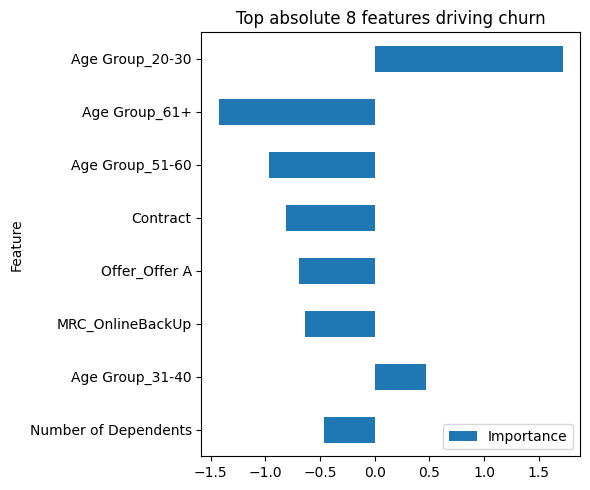

In [15]:
top_abs_features[::-1].plot.barh(x='Feature', y='Importance', figsize=(6,5))
plt.title('Top absolute 8 features driving churn')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
